# Randolph - run STARsolo on long and short reads separately, compare the concordance

Hypothesis:
After personalization, the long and short reads should agree more. 

Before personalization, either long or short should be more "wrong" from the true expression and therefore the correlation will be lower.

In [1]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(stringr)
    library(Matrix)
    library(Matrix.utils)
    library(singlecellmethods)
    library(dplyr)
    library(plyr)
    library(ggrastr)
    library(patchwork)
    library(ggpubr)
    library(reshape2)
})
source('../utils.R')

In [2]:
prefix = '/data/srlab1/jkang/hla/longShort_5prime/'
noPers_long = readRDS(paste0(prefix, 'exp_Randolph2021_noPers_noMM_GeneFull_Exon50pAS_long.rds'))
noPers_short = readRDS(paste0(prefix, 'exp_Randolph2021_noPers_noMM_GeneFull_Exon50pAS_short.rds'))
pers_long = readRDS(paste0(prefix, 'exp_Randolph2021_pers_EM_GeneFull_Exon50pAS_long.rds'))
pers_short = readRDS(paste0(prefix, 'exp_Randolph2021_pers_EM_GeneFull_Exon50pAS_short.rds'))

In [3]:
cell_meta = read.csv('../../data/meta/cell_meta_Randolph_completeHLA.csv')

# Rename 'IMGT' to 'HLA'
rownames(pers_long) = str_replace(rownames(pers_long), 'IMGT_', 'HLA-')
rownames(pers_short) = str_replace(rownames(pers_short), 'IMGT_', 'HLA-')

# Fix duplicated row (gene) names
rownames(pers_long)[which(duplicated(rownames(pers_long)))]
rownames(pers_long) = make.unique(rownames(pers_long)) # fix duplicate rownames
rownames(pers_short)[which(duplicated(rownames(pers_short)))]
rownames(pers_short) = make.unique(rownames(pers_short)) # fix duplicate rownames

[1] "CLCA4-AS1"      "RGS5"           "PROX1-AS1"      "TBCE"          
 [5] "LINC01115"      "LINC01830"      "LINC00486"      "LINC01238"     
 [9] "CYB561D2"       "PRICKLE2-AS1"   "MATR3"          "RAET1E-AS1"    
[13] "LINC01605"      "LINC00484"      "DNAJC9-AS1"     "SPATA13"       
[17] "GOLGA8M"        "SLFN12L"        "SIGLEC5"        "ELFN2"         
[21] "ARMCX5-GPRASP2" "TMSB15B"

[1] "CLCA4-AS1"      "RGS5"           "PROX1-AS1"      "TBCE"          
 [5] "LINC01115"      "LINC01830"      "LINC00486"      "LINC01238"     
 [9] "CYB561D2"       "PRICKLE2-AS1"   "MATR3"          "RAET1E-AS1"    
[13] "LINC01605"      "LINC00484"      "DNAJC9-AS1"     "SPATA13"       
[17] "GOLGA8M"        "SLFN12L"        "SIGLEC5"        "ELFN2"         
[21] "ARMCX5-GPRASP2" "TMSB15B"

Reorder to match cell meta order

In [4]:
pers_long = pers_long[, cell_meta$Cell]
pers_short = pers_short[, cell_meta$Cell]
noPers_long = noPers_long[, cell_meta$Cell]
noPers_short = noPers_short[, cell_meta$Cell]

Log-normalize each cell

In [5]:
pers_long = normalizeData(pers_long, method = "log")
pers_short = normalizeData(pers_short, method = "log")
noPers_long = normalizeData(noPers_long, method = "log")
noPers_short = normalizeData(noPers_short, method = "log")

## Plot improvement in correlations

In [6]:
HLA_genes = c('HLA-A', 'HLA-B', 'HLA-C','HLA-DRB1','HLA-DPA1','HLA-DPB1','HLA-DQA1','HLA-DQB1')
pers_long = pers_long[HLA_genes,]
pers_short = pers_short[HLA_genes,]
noPers_long = noPers_long[HLA_genes,]
noPers_short = noPers_short[HLA_genes,]

Sum across cells per sample | Take the mean (by dividing by number of cells)

In [7]:
pers_long = aggregate.Matrix(t(pers_long), as.factor(cell_meta$Sample), fun = 'sum') # samples x genes
pers_long = pers_long / count(cell_meta$Sample)$freq

pers_short = aggregate.Matrix(t(pers_short), as.factor(cell_meta$Sample), fun = 'sum') # samples x genes
pers_short = pers_short / count(cell_meta$Sample)$freq

noPers_long = aggregate.Matrix(t(noPers_long), as.factor(cell_meta$Sample), fun = 'sum') # samples x genes
noPers_long = noPers_long / count(cell_meta$Sample)$freq

noPers_short = aggregate.Matrix(t(noPers_short), as.factor(cell_meta$Sample), fun = 'sum') # samples x genes
noPers_short = noPers_short / count(cell_meta$Sample)$freq

In [8]:
pers_long_df = as.data.frame(as.matrix(pers_long))
pers_long_df$Sample = rownames(pers_long_df)
pers_long_df$Condition = 'Pers_longReads'
pers_long_long <- pers_long_df %>% pivot_longer(cols=c('HLA-A', 'HLA-B', 'HLA-C', 
                                            'HLA-DPA1', 'HLA-DPB1', 'HLA-DQA1', 'HLA-DQB1', 'HLA-DRB1'),
                    names_to='Gene',
                    values_to='MeanLogCP10k')

noPers_long_df = as.data.frame(as.matrix(noPers_long))
noPers_long_df$Sample = rownames(noPers_long_df)
noPers_long_df$Condition = 'noPers_longReads'
noPers_long_long <- noPers_long_df %>% pivot_longer(cols=c('HLA-A', 'HLA-B', 'HLA-C', 
                                            'HLA-DPA1', 'HLA-DPB1', 'HLA-DQA1', 'HLA-DQB1', 'HLA-DRB1'),
                    names_to='Gene',
                    values_to='MeanLogCP10k')

pers_short_df = as.data.frame(as.matrix(pers_short))
pers_short_df$Sample = rownames(pers_short_df)
pers_short_df$Condition = 'Pers_shortReads'
pers_short_long <- pers_short_df %>% pivot_longer(cols=c('HLA-A', 'HLA-B', 'HLA-C', 
                                            'HLA-DPA1', 'HLA-DPB1', 'HLA-DQA1', 'HLA-DQB1', 'HLA-DRB1'),
                    names_to='Gene',
                    values_to='MeanLogCP10k')

noPers_short_df = as.data.frame(as.matrix(noPers_short))
noPers_short_df$Sample = rownames(noPers_short_df)
noPers_short_df$Condition = 'noPers_shortReads'
noPers_short_long <- noPers_short_df %>% pivot_longer(cols=c('HLA-A', 'HLA-B', 'HLA-C', 
                                            'HLA-DPA1', 'HLA-DPB1', 'HLA-DQA1', 'HLA-DQB1', 'HLA-DRB1'),
                    names_to='Gene',
                    values_to='MeanLogCP10k')

In [9]:
data = rbind(pers_long_long, noPers_long_long, pers_short_long, noPers_short_long) %>% spread(Condition, MeanLogCP10k)
saveRDS(data, 'Randolph_data_long_short.rds')

# Personalized pipeline on AMP 5' gex data

In [10]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(stringr)
    library(Matrix)
    library(Matrix.utils)
    library(singlecellmethods)
    library(dplyr)
    library(plyr)
    library(ggrepel)
    library(patchwork)
})

In [11]:
meta_5p = readRDS('/data/srlab1/jkang/hla/longShort_5prime/AMP5prime_metadata.rds') # From Kaitlyn L.
head(meta_5p)
table(meta_5p$tissue)
meta_5p = meta_5p %>% filter(tissue == 'synovium')
any(duplicated(rownames(meta_5p)))

,nCount_RNA,nFeature_RNA,Cell,sample,donor,tissue,percent.mt,pred_cell_type_broad
,<dbl>,<int>,<fct>,<chr>,<chr>,<chr>,<dbl>,<fct>
Sample_300_0150_PBL_BT_5-AAACCTGAGCTGATAA-1,6839,1648,Sample_300_0150_PBL_BT_5-AAACCTGAGCTGATAA-1,Sample_300_0150_PBL_BT_5,300_0150,blood,4.196520,B
Sample_300_0150_PBL_BT_5-AAACCTGCAAGCCCAC-1,6967,1587,Sample_300_0150_PBL_BT_5-AAACCTGCAAGCCCAC-1,Sample_300_0150_PBL_BT_5,300_0150,blood,2.511842,T
Sample_300_0150_PBL_BT_5-AAACCTGCAAGCGTAG-1,5046,933,Sample_300_0150_PBL_BT_5-AAACCTGCAAGCGTAG-1,Sample_300_0150_PBL_BT_5,300_0150,blood,4.300436,B
Sample_300_0150_PBL_BT_5-AAACCTGCACGCATCG-1,3856,1045,Sample_300_0150_PBL_BT_5-AAACCTGCACGCATCG-1,Sample_300_0150_PBL_BT_5,300_0150,blood,6.224066,B
Sample_300_0150_PBL_BT_5-AAACCTGCATCCGGGT-1,4882,1298,Sample_300_0150_PBL_BT_5-AAACCTGCATCCGGGT-1,Sample_300_0150_PBL_BT_5,300_0150,blood,3.297829,B
Sample_300_0150_PBL_BT_5-AAACCTGCATTTCACT-1,2824,662,Sample_300_0150_PBL_BT_5-AAACCTGCATTTCACT-1,Sample_300_0150_PBL_BT_5,300_0150,blood,4.036827,T



   blood synovium 
   47348    35014 

[1] FALSE

In [12]:
sample_meta = read.csv('../../data/meta/sample_meta_AMP2RA_completeHLA.csv')
head(sample_meta)

,X,Geno_ID,Sample,Age,Site,Case_control,Female,Dataset,gPC1,gPC2,gPC3,gPC4,gPC5
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,BRI-399,301-0267,BRI-399,70,University of Pittsburgh,OA,1,AMP2RA,0.00697193,-0.001935340,-0.00341045,-0.005422540,0.001496150
2,BRI-401,300-0302,BRI-401,77,Cedars,RA,1,AMP2RA,0.00504535,-0.000640029,0.00543787,0.001750970,-0.000925546
3,BRI-403,300-0150,BRI-403,28,University of Rochester,RA,1,AMP2RA,0.00656045,-0.001213060,-0.00653968,-0.003942930,0.000739538
4,BRI-405,300-0310,BRI-405,62,Cedars,RA,1,AMP2RA,-0.05157130,-0.016638500,-0.00622098,0.000976913,-0.003088850
5,BRI-407,300-2663,BRI-407,44,Columbia University,RA,1,AMP2RA,-0.02314780,-0.006370860,-0.00491758,0.010194300,-0.002749720
6,BRI-409,300-0460,BRI-409,68,Northwestern,RA,1,AMP2RA,0.00704854,-0.002764350,-0.00464487,-0.003911500,0.001053590


In [13]:
sample_meta$sample = str_replace(sample_meta$Geno_ID, '-', '_')
unique(sample_meta$sample)
unique(meta_5p$donor)[-which(unique(meta_5p$donor) %in% sample_meta$sample)]

[1] "301_0267"           "300_0302"           "300_0150"          
 [4] "300_0310"           "300_2663"           "300_0460"          
 [7] "300_0309"           "300_1933"           "300_0228-V0-08-L1" 
[10] "300_2669"           "300_0501"           "300_0408"          
[13] "300_0414"           "300_2662"           "300_0453"          
[16] "300_0223"           "301_0269"           "301_0168"          
[19] "301_1470"           "300_0173"           "300_1930"          
[22] "301_1468"           "300_0174"           "300_1929"          
[25] "300_0489"           "301_0166"           "300_0502"          
[28] "300_0392-V0-14-BC1" "300_0488"           "300_2660"          
[31] "300_2665"           "300_0504"           "301_0268"          
[34] "300_0175"           "300_0221"           "300_2671"          
[37] "300_0226"           "300_0491"           "300_0307"          
[40] "300_0507-F2-17-L1"  "300_2651"           "300_0144"          
[43] "300_2600"           "300_0172"           "300_0183-V0-07-BC1"
[46] "300_0529"           "300_0171"           "300_2668"          
[49] "300_0149"           "300_0532"           "300_0416-V0-14-L1" 
[52] "300_0176"           "300_2601"           "300_0410"          
[55] "300_1881-F2-17-L1"  "301_0169"           "300_0145"          
[58] "300_0506-F2-17-L1"  "300_2657"           "301_1469"          
[61] "300_0151-V0-05-L1"  "300_0235-V0-08-L1"  "300_0415"          
[64] "300_0417"           "300_0418"           "300_1879-F2-17-L1" 
[67] "300_1880-F1-17-L1"  "300_0251"           "300_0464"

[1] "300_0392" "300_0416" "300_1883" "301_0174" "301_0270"

In [14]:
unique(meta_5p$donor)
which(unique(meta_5p$donor) %in% sample_meta$sample)
any(grepl('300_0392', sample_meta$sample))
any(grepl('300_0416', sample_meta$sample))
any(grepl('300_1883', sample_meta$sample))
any(grepl('301_0174', sample_meta$sample))
any(grepl('301_0270', sample_meta$sample))

unique(meta_5p$sample)
unique(meta_5p$donor)
meta_5p$Cell = rownames(meta_5p)
write.csv(meta_5p, '../../data/meta/AMP5prime_metadata_Syn.csv')

[1] "300_0150" "300_0171" "300_0173" "300_0174" "300_0392" "300_0410"
 [7] "300_0414" "300_0416" "300_1883" "300_1930" "301_0174" "301_0270"

[1]  1  2  3  4  6  7 10

[1] TRUE

[1] TRUE

[1] FALSE

[1] FALSE

[1] FALSE

[1] "Sample_300_0150_Syn_BT_5" "Sample_300_0171_Syn_BT_5"
 [3] "Sample_300_0173_Syn_BT_5" "Sample_300_0174_Syn_BT_5"
 [5] "Sample_300_0392_Syn_BT_5" "Sample_300_0410_Syn_BT_5"
 [7] "Sample_300_0414_Syn_BT_5" "Sample_300_0416_Syn_BT_5"
 [9] "Sample_300_1883_Syn_BT_5" "Sample_300_1930_Syn_BT_5"
[11] "Sample_301_0174_Syn_BT_5" "Sample_301_0174_Syn_PC_5"
[13] "Sample_301_0270_Syn_BT_5"

[1] "300_0150" "300_0171" "300_0173" "300_0174" "300_0392" "300_0410"
 [7] "300_0414" "300_0416" "300_1883" "300_1930" "301_0174" "301_0270"

## Match sample names with 3p dataset

In [15]:
meta_5p$Geno_ID = str_replace(meta_5p$donor, '_', '-')
meta_5p$Geno_ID[which(meta_5p$Geno_ID == '300-0392')] = '300-0392-V0-14-BC1'
meta_5p$Geno_ID[which(meta_5p$Geno_ID == '300-0416')] = '300-0416-V0-14-L1'
unique(meta_5p$Geno_ID)
meta_5p = meta_5p %>% filter(Geno_ID %in% sample_meta$Geno_ID)
unique(meta_5p$Geno_ID)

[1] "300-0150"           "300-0171"           "300-0173"          
 [4] "300-0174"           "300-0392-V0-14-BC1" "300-0410"          
 [7] "300-0414"           "300-0416-V0-14-L1"  "300-1883"          
[10] "300-1930"           "301-0174"           "301-0270"

[1] "300-0150"           "300-0171"           "300-0173"          
[4] "300-0174"           "300-0392-V0-14-BC1" "300-0410"          
[7] "300-0414"           "300-0416-V0-14-L1"  "300-1930"

9 samples with matching 3' data

In [16]:
head(meta_5p)
meta_5p = left_join(meta_5p, sample_meta[, c('Geno_ID', 'Sample')], by = 'Geno_ID')
meta_5p$Sample %>% unique()
unique(paste(meta_5p$Sample, meta_5p$Geno_ID))
unique(paste(meta_5p$Sample, meta_5p$sample))

,nCount_RNA,nFeature_RNA,Cell,sample,donor,tissue,percent.mt,pred_cell_type_broad,Geno_ID
,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<chr>
Sample_300_0150_Syn_BT_5-AAACCTGAGAACTGTA-1,8321,2344,Sample_300_0150_Syn_BT_5-AAACCTGAGAACTGTA-1,Sample_300_0150_Syn_BT_5,300_0150,synovium,3.653407,T,300-0150
Sample_300_0150_Syn_BT_5-AAACCTGAGAATTGTG-1,4597,1068,Sample_300_0150_Syn_BT_5-AAACCTGAGAATTGTG-1,Sample_300_0150_Syn_BT_5,300_0150,synovium,8.918860,B,300-0150
Sample_300_0150_Syn_BT_5-AAACCTGAGAGGACGG-1,14539,2911,Sample_300_0150_Syn_BT_5-AAACCTGAGAGGACGG-1,Sample_300_0150_Syn_BT_5,300_0150,synovium,4.862783,B,300-0150
Sample_300_0150_Syn_BT_5-AAACCTGCACGGCTAC-1,1704,504,Sample_300_0150_Syn_BT_5-AAACCTGCACGGCTAC-1,Sample_300_0150_Syn_BT_5,300_0150,synovium,10.211268,T,300-0150
Sample_300_0150_Syn_BT_5-AAACCTGGTATAGTAG-1,7140,2027,Sample_300_0150_Syn_BT_5-AAACCTGGTATAGTAG-1,Sample_300_0150_Syn_BT_5,300_0150,synovium,4.663866,T,300-0150
Sample_300_0150_Syn_BT_5-AAACCTGTCTTGACGA-1,6829,1723,Sample_300_0150_Syn_BT_5-AAACCTGTCTTGACGA-1,Sample_300_0150_Syn_BT_5,300_0150,synovium,4.407673,T,300-0150


[1] "BRI-403" "BRI-556" "BRI-460" "BRI-479" "BRI-505" "BRI-583" "BRI-427"
[8] "BRI-566" "BRI-462"

[1] "BRI-403 300-0150"           "BRI-556 300-0171"          
[3] "BRI-460 300-0173"           "BRI-479 300-0174"          
[5] "BRI-505 300-0392-V0-14-BC1" "BRI-583 300-0410"          
[7] "BRI-427 300-0414"           "BRI-566 300-0416-V0-14-L1" 
[9] "BRI-462 300-1930"

[1] "BRI-403 Sample_300_0150_Syn_BT_5" "BRI-556 Sample_300_0171_Syn_BT_5"
[3] "BRI-460 Sample_300_0173_Syn_BT_5" "BRI-479 Sample_300_0174_Syn_BT_5"
[5] "BRI-505 Sample_300_0392_Syn_BT_5" "BRI-583 Sample_300_0410_Syn_BT_5"
[7] "BRI-427 Sample_300_0414_Syn_BT_5" "BRI-566 Sample_300_0416_Syn_BT_5"
[9] "BRI-462 Sample_300_1930_Syn_BT_5"

In [17]:
meta_5p = separate(meta_5p, col = Cell, into = c('Cell1', 'Cell2', 'Cell3'), sep = '-')
meta_5p$Cell = paste(meta_5p$Sample, meta_5p$Cell2, sep = '_')
rownames(meta_5p) = meta_5p$Cell
head(meta_5p)
write.csv(meta_5p, '../../data/meta/AMP5prime_metadata_Syn.csv')

,nCount_RNA,nFeature_RNA,Cell1,Cell2,Cell3,sample,donor,tissue,percent.mt,pred_cell_type_broad,Geno_ID,Sample,Cell
,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<chr>,<chr>,<chr>
BRI-403_AAACCTGAGAACTGTA,8321,2344,Sample_300_0150_Syn_BT_5,AAACCTGAGAACTGTA,1,Sample_300_0150_Syn_BT_5,300_0150,synovium,3.653407,T,300-0150,BRI-403,BRI-403_AAACCTGAGAACTGTA
BRI-403_AAACCTGAGAATTGTG,4597,1068,Sample_300_0150_Syn_BT_5,AAACCTGAGAATTGTG,1,Sample_300_0150_Syn_BT_5,300_0150,synovium,8.918860,B,300-0150,BRI-403,BRI-403_AAACCTGAGAATTGTG
BRI-403_AAACCTGAGAGGACGG,14539,2911,Sample_300_0150_Syn_BT_5,AAACCTGAGAGGACGG,1,Sample_300_0150_Syn_BT_5,300_0150,synovium,4.862783,B,300-0150,BRI-403,BRI-403_AAACCTGAGAGGACGG
BRI-403_AAACCTGCACGGCTAC,1704,504,Sample_300_0150_Syn_BT_5,AAACCTGCACGGCTAC,1,Sample_300_0150_Syn_BT_5,300_0150,synovium,10.211268,T,300-0150,BRI-403,BRI-403_AAACCTGCACGGCTAC
BRI-403_AAACCTGGTATAGTAG,7140,2027,Sample_300_0150_Syn_BT_5,AAACCTGGTATAGTAG,1,Sample_300_0150_Syn_BT_5,300_0150,synovium,4.663866,T,300-0150,BRI-403,BRI-403_AAACCTGGTATAGTAG
BRI-403_AAACCTGTCTTGACGA,6829,1723,Sample_300_0150_Syn_BT_5,AAACCTGTCTTGACGA,1,Sample_300_0150_Syn_BT_5,300_0150,synovium,4.407673,T,300-0150,BRI-403,BRI-403_AAACCTGTCTTGACGA


## Combine lanes

In [18]:
samples = read.table('/data/srlab2/jkang/scHLA/AMP_RA_repertoire/gex/fastq/sample.list')
samples

V1,V2
<chr>,<chr>
300_0150_Syn_BT_5,BRI-403
300_0171_Syn_BT_5,BRI-556
300_0173_Syn_BT_5,BRI-460
300_0174_Syn_BT_5,BRI-479
300_0392_Syn_BT_5,BRI-505
300_0410_Syn_BT_5,BRI-583
300_0414_Syn_BT_5,BRI-427
300_0416_Syn_BT_5,BRI-566
300_1930_Syn_BT_5,BRI-462


In [24]:
logs_dir = '/data/srlab2/jkang/scHLA/AMP_RA_repertoire/gex/fastq/logs/'
script = '/data/srlab2/jkang/scHLA/AMP_RA_repertoire/gex/fastq/combine_lanes.sh'
for (i in 2:nrow(samples)) {
    a = samples[i, 1]
    b = samples[i, 2]
    s = paste0('bsub -q normal -M 8000 -R "rusage[mem=8000]" -n 4 -J combine_', a, 
                   ' -R "select[hname!=cn001]" -R "select[hname!=cn002]" -R "select[hname!=cn003]" -R "select[hname!=cn004]" -R "select[hname!=cn005]" -R "select[hname!=cn007]"', 
                   ' -o ', logs_dir, a, '.out -e ', logs_dir, a, '.err',
                   ' "bash ', script, ' ', paste(a, b, '"'))
    print(s)
}

[1] "bsub -q normal -M 8000 -R \"rusage[mem=8000]\" -n 4 -J combine_300_0171_Syn_BT_5 -R \"select[hname!=cn001]\" -R \"select[hname!=cn002]\" -R \"select[hname!=cn003]\" -R \"select[hname!=cn004]\" -R \"select[hname!=cn005]\" -R \"select[hname!=cn007]\" -o /data/srlab2/jkang/scHLA/AMP_RA_repertoire/gex/fastq/logs/300_0171_Syn_BT_5.out -e /data/srlab2/jkang/scHLA/AMP_RA_repertoire/gex/fastq/logs/300_0171_Syn_BT_5.err \"bash /data/srlab2/jkang/scHLA/AMP_RA_repertoire/gex/fastq/combine_lanes.sh 300_0171_Syn_BT_5 BRI-556 \""
[1] "bsub -q normal -M 8000 -R \"rusage[mem=8000]\" -n 4 -J combine_300_0173_Syn_BT_5 -R \"select[hname!=cn001]\" -R \"select[hname!=cn002]\" -R \"select[hname!=cn003]\" -R \"select[hname!=cn004]\" -R \"select[hname!=cn005]\" -R \"select[hname!=cn007]\" -o /data/srlab2/jkang/scHLA/AMP_RA_repertoire/gex/fastq/logs/300_0173_Syn_BT_5.out -e /data/srlab2/jkang/scHLA/AMP_RA_repertoire/gex/fastq/logs/300_0173_Syn_BT_5.err \"bash /data/srlab2/jkang/scHLA/AMP_RA_repertoire/gex

## Read in 5-prime counts matrices

In [19]:
noPers_5p = readRDS('../../data/genesXcells_GeneFull_Ex50pAS/exp_AMP2RA_5prime_noPers_noMM_GeneFull_Exon50pAS.rds')
pers_5p = readRDS('../../data/genesXcells_GeneFull_Ex50pAS/exp_AMP2RA_5prime_pers_EM_GeneFull_Exon50pAS.rds')
meta_5p = read.csv(paste0('../../data/meta/AMP5prime_metadata_Syn.csv'), row.names = 1)

HLA_genes = c('HLA-A', 'HLA-B', 'HLA-C', 'HLA-DRB1', 'HLA-DQA1', 'HLA-DQB1', 'HLA-DPA1', 'HLA-DPB1')
IMGT_genes = c('IMGT_A', 'IMGT_B', 'IMGT_C', 'IMGT_DRB1', 'IMGT_DQA1', 'IMGT_DQB1', 'IMGT_DPA1', 'IMGT_DPB1')
length(rownames(meta_5p))
length(colnames(pers_5p))

# Reorder cells to match the metadata ordering
pers_5p = pers_5p[, rownames(meta_5p)]
noPers_5p = noPers_5p[, rownames(meta_5p)]

# Rename 'IMGT' to 'HLA'
rownames(pers_5p) = str_replace(rownames(pers_5p), 'IMGT_', 'HLA-')
dim(pers_5p)
dim(noPers_5p)
noPers_5p = noPers_5p[rownames(pers_5p), ]

[1] 26638

[1] 26638

[1] 36571 26638

[1] 36571 26638

In [20]:
# Sum by sample
pers_sample = rowsum(as.matrix(t(pers_5p)), meta_5p$Sample, reorder = TRUE)
noPers_sample = rowsum(as.matrix(t(noPers_5p)), meta_5p$Sample, reorder = TRUE)

# Subset to HLA genes
pers_sample = pers_sample[, HLA_genes]
noPers_sample = noPers_sample[, HLA_genes]

pctinc = 100 * (pers_sample - noPers_sample) / noPers_sample

pctinc_long <- reshape2::melt(data = pctinc, 
                id.vars = colnames(pctinc),
                variable.name = "gene",
                value.name = "pct_change")
colnames(pctinc_long) = c('sample', 'gene', 'pct_change')

png 
  2

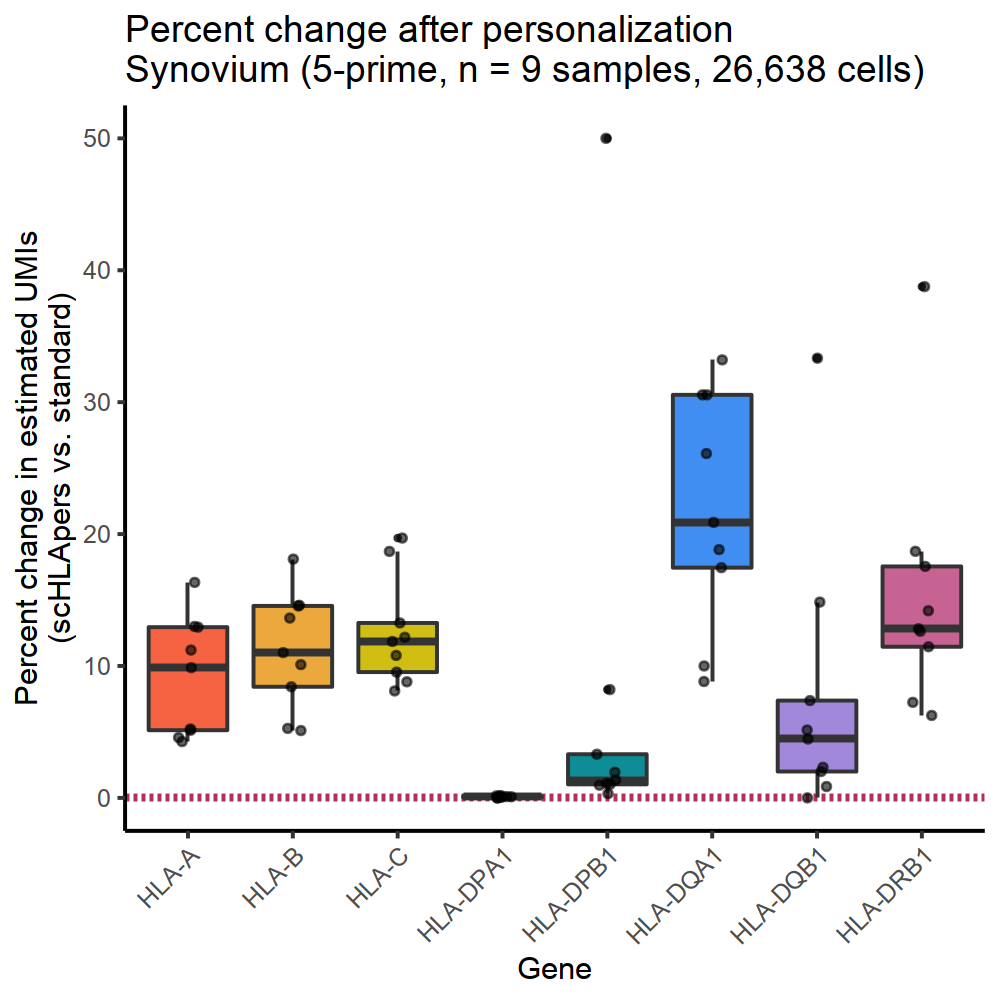

In [58]:
fig.size(5, 5)
pdf(file = '../../SuppFigs/Percent_change_AMP2RA_5prime.pdf', width = 5, height = 5)
p = ggplot(pctinc_long) +
    geom_hline(yintercept=0, color = 'maroon', size = 1, linetype = 'dashed') +
    geom_boxplot(aes(x = as.character(gene), y = pct_change, fill = as.character(gene)), outlier.size = 0.5) + 
    geom_jitter(aes(x = as.character(gene), y = pct_change), col = 'black', alpha = 0.6, size = 1, width = 0.1) +
    theme_bw() +
    xlab('Gene') + ggtitle('Percent change after personalization\nSynovium (5-prime, n = 9 samples, 26,638 cells)') + 
    ylab('Percent change in estimated UMIs\n(scHLApers vs. standard)') + 
    theme_classic() + theme(legend.position = 'none') +
    scale_fill_manual(values = gene_colors) +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) 
print(p)
dev.off()
p

# Done!

In [28]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/jbk37/anaconda3/envs/hla_new/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ggrepel_0.9.1           reshape2_1.4.4          ggpubr_0.4.0           
 [4] patchwork_1.1.1         ggrastr_1.0.1           plyr_1.8.6             
 [7] singlecellmethods_0.1.0 data.table_1.14.2       Matrix.utils_0.9.8     
[10] Matrix_1.4-0            forcat